In [1]:
from Bio.PDB import *
from Bio.PDB.DSSP import DSSP
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
from Bio import SeqIO

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as linalg
from scipy import sparse
import scipy.signal
from snf import *

import gudhi as gd

def getUnweightedLaplacianEigsDense(W):
    D = sparse.dia_matrix((W.sum(1).flatten(), 0), W.shape).toarray()
    L = D - W
    try:
        _, v = linalg.eigh(L)
    except:
        return np.zeros_like(W)
    return v

def get_csm(X, Y):
    if len(X.shape) == 1:
        X = X[:, None]
    if len(Y.shape) == 1:
        Y = Y[:, None]
    C = np.sum(X**2, 1)[:, None] + np.sum(Y**2, 1)[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    return np.sqrt(C)


def csm_to_binary(D, kappa):
    N = D.shape[0]
    M = D.shape[1]
    if kappa == 0:
        return np.ones_like(D)
    elif kappa < 1:
        NNeighbs = int(np.round(kappa*M))
    else:
        NNeighbs = kappa
    J = np.argpartition(D, NNeighbs, 1)[:, 0:NNeighbs]
    I = np.tile(np.arange(N)[:, None], (1, NNeighbs))
    V = np.ones(I.size)
    [I, J] = [I.flatten(), J.flatten()]
    ret = sparse.coo_matrix((V, (I, J)), shape=(N, M), dtype=np.uint8)
    return ret.toarray()

def csm_to_binary_mutual(D, kappa):
    return csm_to_binary(D, kappa)*(csm_to_binary(D.T, kappa).T)

def sliding_window(dist, win):
    N = D.shape[0]
    dist_stack = np.zeros((N-win+1, N-win+1))
    for i in range(0, win):
        dist_stack += dist[i:i+N-win+1, i:i+N-win+1]
    for i in range(N-win+1):
        dist_stack[i, i] = 0
    return dist_stack

In [8]:
protid = "6909_T154-R1"
clade = 'Int9878_431_495_R_323'

parser = PDBParser()
structure = parser.get_structure(protid, "pdb/%s.pdb"%protid)

foundChain = False
for model in structure:
    for chain in model:
        if chain.id == 'A':
            foundChain = True
            break
    if foundChain:
        break

dssp = DSSP(model, "pdb/%s.pdb"%protid)
beta = []
for key in list(dssp.keys()):
    if dssp[key][2] == 'E':
        beta.append(dssp[key][0])

for record in SeqIO.parse('orthogroup_LRR/%s-LRR.fa'%clade, 'fasta'):
    if record.id.startswith(protid):    
        LRR_start = int(record.name.split('|')[1])
        LRR_len = int(len(record))        

        print(LRR_start)
        break
            

In [9]:
f = open("LRRPredictor/athaliana_panNLRome_lrrpred.txt", "r")
startrpred = []
for line in f:
        if line.split()[0] == protid:
            startrpred.append(int(line.split()[1])-LRR_start)    
f.close()

In [10]:
alpha_carbons = []
for atom in chain.get_atoms():
    if atom.id == 'CA':
        alpha_carbons.append(np.array(list(atom.get_vector())))
        
X = np.array(alpha_carbons)
np.savetxt('csv/%s.csv'%protid, X, delimiter=',')

In [11]:
windowSize = 30
totpers_l=[]
for windowStart in range(X.shape[0]- windowSize-1):
    Y = X[windowStart:windowStart+windowSize,:]
    stree = gd.AlphaComplex(points = Y).create_simplex_tree()
    dgm = stree.persistence()
    dgm1_lens = [d-b for (dim, (b, d)) in dgm if dim == 1]
    dgmstat = sum(dgm1_lens)
    # gd.plot_persistence_diagram(dgm, legend = True)
    totpers_l.append(dgmstat)


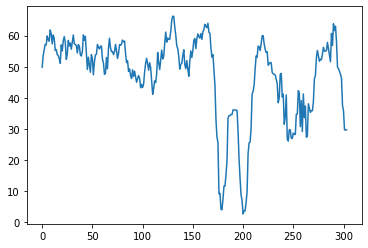

In [12]:
plt.plot(totpers_l)

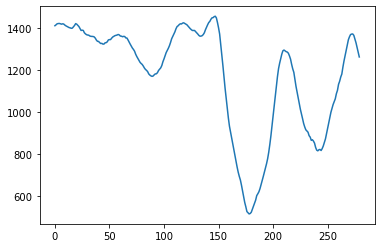

In [13]:
period = 25

def persistence(arr, win):
    n = len(arr)
    pers = []
 
    for i in range(n - win + 1):
        sum = 0
        for j in range(win):
           sum += arr[i + j]
        pers.append(sum)
 
    return pers

totpers_2 = persistence(totpers_l, period)

plt.plot(totpers_2)